In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm.notebook import tqdm



In [3]:
# Add src to path
sys.path.append('..')

from src.baselines.models import SeasonalNaive, MovingAverage
from src.baselines.optimized import PiecewiseHybrid

# Setup
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [10]:

# Chemins (à ajuster si besoin, suppose lancé depuis la racine ou notebooks/)
DATA_DIR = "../data/processed"

df_weekly = pd.read_parquet(f"{DATA_DIR}/weekly_data.parquet")

print(df_weekly.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434808 entries, 0 to 434807
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   year_week      434808 non-null  UInt32        
 1   store_nbr      434808 non-null  int16         
 2   family         434808 non-null  object        
 3   sales          434808 non-null  float64       
 4   onpromotion    434808 non-null  int16         
 5   dcoilwtico     434808 non-null  float64       
 6   is_holiday     434808 non-null  int8          
 7   holiday_count  434808 non-null  int8          
 8   week_start     434808 non-null  datetime64[ns]
dtypes: UInt32(1), datetime64[ns](1), float64(2), int16(2), int8(2), object(1)
memory usage: 17.8+ MB
None


In [6]:
print(df_weekly.columns)

Index(['year_week', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'is_holiday', 'holiday_count', 'week_start'],
      dtype='object')


In [9]:
display(df_weekly.head())

,year_week,store_nbr,family,sales,onpromotion,dcoilwtico,is_holiday,holiday_count,week_start
0,201301,1,AUTOMOTIVE,15.0,0,93.101667,1,2,2013-01-01
1,201301,1,BABY CARE,0.0,0,93.101667,1,2,2013-01-01
2,201301,1,BEAUTY,8.0,0,93.101667,1,2,2013-01-01
3,201301,1,BEVERAGES,4530.0,0,93.101667,1,2,2013-01-01
4,201301,1,BOOKS,0.0,0,93.101667,1,2,2013-01-01


In [7]:
df_daily_full = pd.read_parquet(f"{DATA_DIR}/daily_canon.parquet")


print(df_daily_full.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3036528 entries, 0 to 3036527
Data columns (total 28 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[ns]
 1   store_nbr             int16         
 2   family                category      
 3   id                    float64       
 4   sales                 float64       
 5   onpromotion           int16         
 6   set                   object        
 7   city                  object        
 8   state                 object        
 9   type                  object        
 10  cluster               int16         
 11  dcoilwtico            float64       
 12  transactions          float64       
 13  transactions_missing  int8          
 14  is_holiday            int8          
 15  is_event              int8          
 16  is_workday            int8          
 17  is_bridge             int8          
 18  is_transfer_type      int8          
 19  

In [8]:

display(df_daily_full.head())


,date,store_nbr,family,id,sales,onpromotion,set,city,state,type,cluster,dcoilwtico,transactions,transactions_missing,is_holiday,is_event,is_workday,is_bridge,is_transfer_type,n_holidays,n_events,day_of_week,is_weekend,month,year,is_payday_proxy,is_train_day,is_test_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0,train,Quito,Pichincha,D,13,93.14,1746.0,1,1,0,0,0,0,1,0,1,0,1,2013,0,1,0
1,2013-01-01,1,BABY CARE,1.0,0.0,0,train,Quito,Pichincha,D,13,93.14,1746.0,1,1,0,0,0,0,1,0,1,0,1,2013,0,1,0
2,2013-01-01,1,BEAUTY,2.0,0.0,0,train,Quito,Pichincha,D,13,93.14,1746.0,1,1,0,0,0,0,1,0,1,0,1,2013,0,1,0
3,2013-01-01,1,BEVERAGES,3.0,0.0,0,train,Quito,Pichincha,D,13,93.14,1746.0,1,1,0,0,0,0,1,0,1,0,1,2013,0,1,0
4,2013-01-01,1,BOOKS,4.0,0.0,0,train,Quito,Pichincha,D,13,93.14,1746.0,1,1,0,0,0,0,1,0,1,0,1,2013,0,1,0


In [11]:
# Pour le pétrole
df_oil = df_daily_full[['date', 'dcoilwtico']].drop_duplicates()


In [12]:


cols_events = ['date', 'type', 'locale', 'locale_name']
# On prend l'intersection pour éviter une erreur si une colonne manque
existing_cols = [c for c in cols_events if c in df_daily_full.columns]
df_events = df_daily_full[existing_cols].drop_duplicates()

print(f"\nExtraction terminée : {len(df_oil)} prix pétrole, {len(df_events)} événements.")


Extraction terminée : 1704 prix pétrole, 8520 événements.


## 1. L'Hypothèse du Pétrole (The Oil Myth)

L'Équateur est une économie fortement dépendante de ses exportations de pétrole.
L'intuition (Business Belief) est la suivante :
> *"Quand le prix du baril chute, l'économie locale ralentit, le pouvoir d'achat baisse, et donc les ventes en magasin diminuent."*

Si cette corrélation est avérée, le prix du pétrole (`dcoilwtico`) devient un **Leading Indicator** (Indicateur avancé) précieux pour prédire les tendances de fond à moyen terme.
Si elle est fausse, c'est du bruit inutile qui va perturber notre modèle. **Nous allons donc vérifier factuellement si cette corrélation existe.**

In [13]:
# Agrégation des ventes totales par jour
daily_sales = pd.read_parquet(f"{DATA_DIR}/daily_canon.parquet")
daily_total = daily_sales.groupby("date")["sales"].sum().reset_index()

# Merge avec les prix du pétrole
# On utilise inner join pour ne garder que les jours où on a les deux infos
oil_analysis = daily_total.merge(df_oil, on="date", how="inner")


Corrélation Instantanée (Daily) : -0.5778


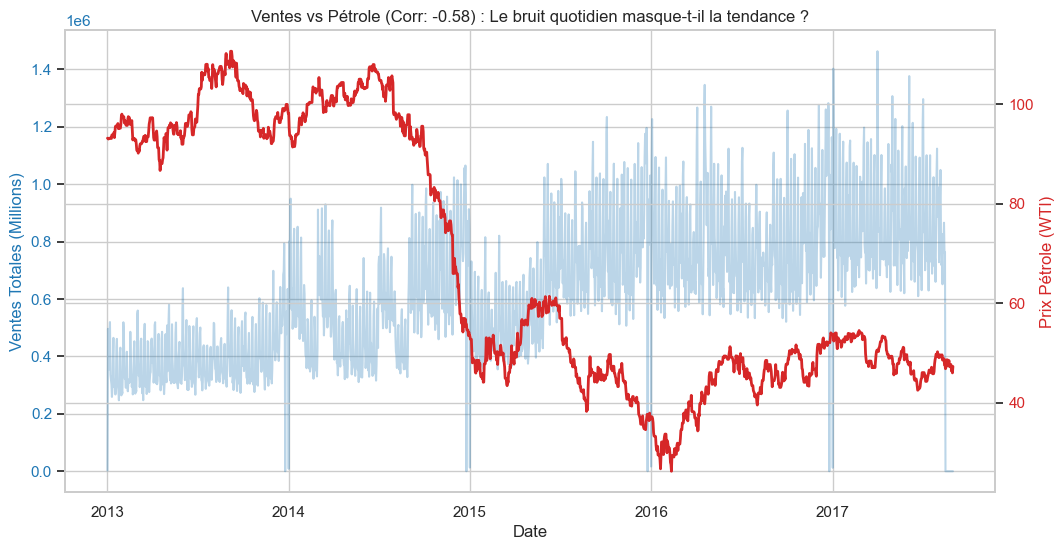

In [14]:

corr_day = oil_analysis['sales'].corr(oil_analysis['dcoilwtico'])
print(f"Corrélation Instantanée (Daily) : {corr_day:.4f}")

# Visualisation Double Axe
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Ventes Totales (Millions)', color=color)
ax1.plot(oil_analysis['date'], oil_analysis['sales'], color=color, alpha=0.3, label='Ventes Daily')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Prix Pétrole (WTI)', color=color)
ax2.plot(oil_analysis['date'], oil_analysis['dcoilwtico'], color=color, linewidth=2, label='Prix Pétrole')
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f"Ventes vs Pétrole (Corr: {corr_day:.2f}) : Le bruit quotidien masque-t-il la tendance ?")
plt.show()


C:\Users\gouab\AppData\Local\Temp\ipykernel_380\1370543410.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = oil_analysis.set_index('date').resample('M').mean()


Corrélation avec 0 mois de retard : -0.7576
Corrélation avec 1 mois de retard : -0.7281
Corrélation avec 2 mois de retard : -0.7193
Corrélation avec 3 mois de retard : -0.7094
Corrélation avec 6 mois de retard : -0.7269


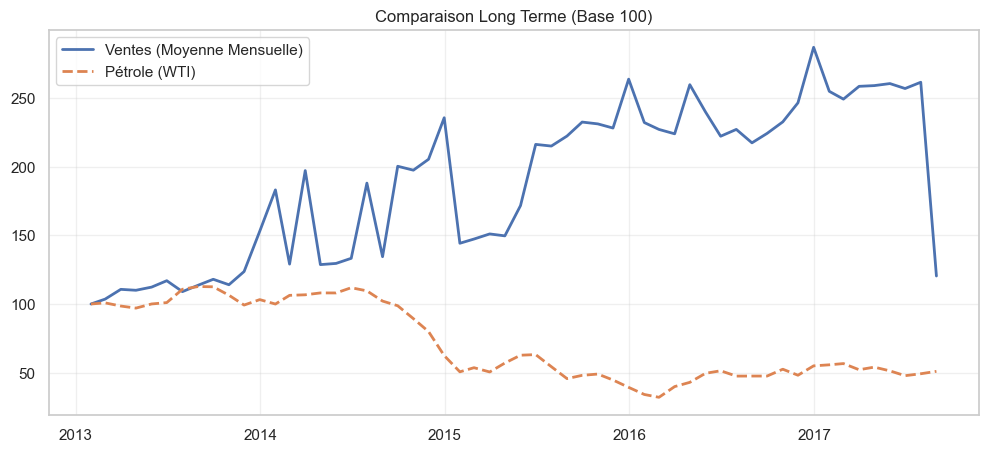

In [15]:

# On passe en mensuel (Moyenne) pour supprimer le bruit (weekend, promo flash...)
monthly = oil_analysis.set_index('date').resample('M').mean()

# Test des décalages (Le pétrole d'aujourd'hui impacte-t-il les ventes dans X mois ?)
for lag in [0, 1, 2, 3, 6]:
    c = monthly['sales'].corr(monthly['dcoilwtico'].shift(lag))
    print(f"Corrélation avec {lag} mois de retard : {c:.4f}")

# Visualisation Normalisée (Base 100) pour comparer les courbes
monthly_norm = monthly / monthly.iloc[0] * 100
plt.figure(figsize=(12, 5))
plt.plot(monthly_norm.index, monthly_norm['sales'], label='Ventes (Moyenne Mensuelle)', linewidth=2)
plt.plot(monthly_norm.index, monthly_norm['dcoilwtico'], label='Pétrole (WTI)', linestyle='--', linewidth=2)
plt.title("Comparaison Long Terme (Base 100)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

On regarde si un CHANGEMENT de prix provoque un CHANGEMENT de ventes (pour éliminer la tendance de fond).
Corrélation des variations (Montant vs Montant) : 0.0241


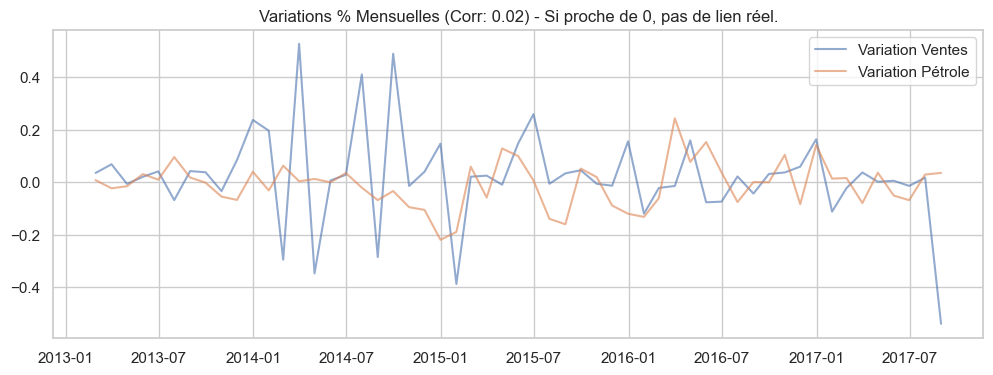

In [16]:

print("On regarde si un CHANGEMENT de prix provoque un CHANGEMENT de ventes (pour éliminer la tendance de fond).")

# Calcul des variations mensuelles en %
monthly_diff = monthly.pct_change().dropna()

# Nouvelle corrélation
corr_diff = monthly_diff['sales'].corr(monthly_diff['dcoilwtico'])
print(f"Corrélation des variations (Montant vs Montant) : {corr_diff:.4f}")

# Visualisation des sauts
plt.figure(figsize=(12, 4))
plt.plot(monthly_diff.index, monthly_diff['sales'], label='Variation Ventes', alpha=0.6)
plt.plot(monthly_diff.index, monthly_diff['dcoilwtico'], label='Variation Pétrole', alpha=0.6)
plt.title(f"Variations % Mensuelles (Corr: {corr_diff:.2f}) - Si proche de 0, pas de lien réel.")
plt.legend()
plt.show()

### Une Fausse Piste (Spurious Correlation)

L'analyse révèle un piège classique :
1.  **En apparence**, une très forte corrélation négative (`-0.75`) : les ventes augmentent quand le pétrole baisse.
2.  **En réalité**, c'est une coïncidence. Les ventes augmentent structurellement (croissance du magasin) tandis que le pétrole baisse mondialement sur la période.
3.  **La Preuve** : En corrélant les *variations* mensuelles, le lien disparaît totalement (`0.02`). Une variation du prix du pétrole n'entraîne aucune variation des ventes.

La variable `dcoilwtico` ne sera **PAS** utilisée comme feature principale dans le modèle pour éviter d'introduire du bruit.

## 2. L'Hypothèse du Payday (La Quinzaine)
Contrairement à l'Europe où le salaire est souvent mensuel, en Équateur, il est courant de recevoir son salaire en deux fois :
1.  Le **15 du mois** (La Quinzaine).
2.  Le **dernier jour du mois**.
L'hypothèse est simple : **"Pas d'argent, pas de courses. Jour de paie, caddie plein."**
Si cette saisonnalité est forte, le jour du mois (`day_of_month`) devient une feature critique. Le modèle doit savoir si on est le 14 (fauchés) ou le 16 (riches).

In [17]:
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month

# On exclut Décembre pour voir la "vraie" routine (hors Noël)
# Cela permet de nettoyer le signal
clean_data = daily_sales[daily_sales['month'] != 12]

# Agrégation moyenne par jour du mois
payday_profile = clean_data.groupby('day')['sales'].mean()

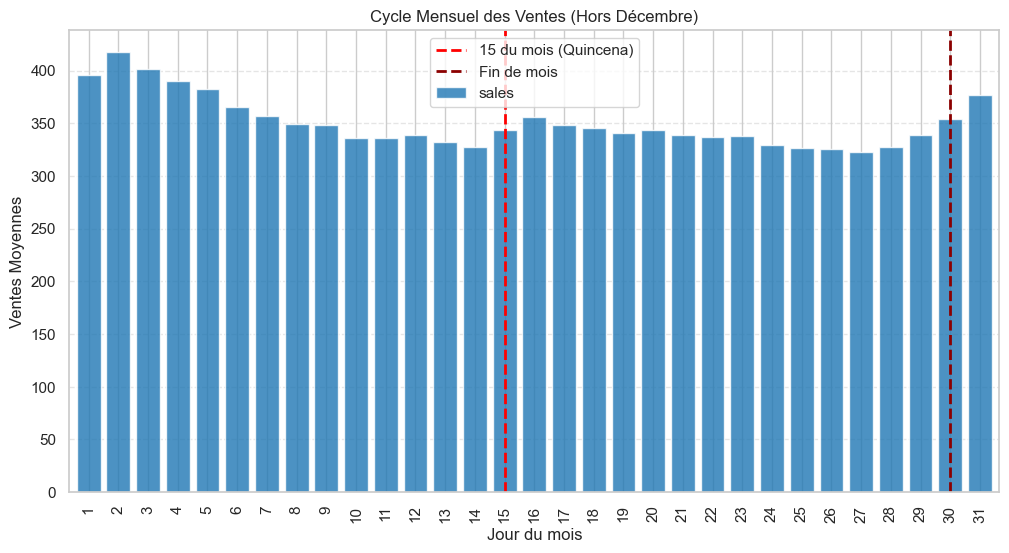

In [18]:

plt.figure(figsize=(12, 6))

payday_profile.plot(kind='bar', color='#1f77b4', zorder=2, alpha=0.8, width=0.8)

plt.title("Cycle Mensuel des Ventes (Hors Décembre)")
plt.xlabel("Jour du mois")
plt.ylabel("Ventes Moyennes")

plt.axvline(x=14, color='red', linestyle='--', linewidth=2, label='15 du mois (Quincena)')
plt.axvline(x=29, color='darkred', linestyle='--', linewidth=2, label='Fin de mois')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


L'analyse visuelle confirme totalement l'hypothèse :
1.  **Vagues de Consommation** : On observe deux cycles clairs par mois, calés sur les paies.
2.  **L'Effet 1er du Mois** : Le plus gros pic d'achats se fait juste après la paie de fin de mois (jours 1, 2, 3).
3.  **L'Effet Quinzaine** : Un rebond significatif est visible autour du 15-16.

Le "Jour du mois" est une feature prédictive, mais elle doit être traitée intelligemment par le modèle (il ne s'agit pas d'une relation linéaire, mais cyclique).

## 3. L'Hypothèse de la Rareté (Sparsity Check)

Dans la grande distribution, tous les produits ne sont pas des best-sellers comme le pain ou le lait. Beaucoup d'articles se vendent de manière **intermittente** (quelques ventes par semaine, puis rien).

**Pourquoi c'est important ?**
Si notre historique contient une majorité de zéros :
1.  Les métriques classiques (RMSE) deviennent trompeuses.
2.  Nous devrons peut-être utiliser des modèles spécifiques (Poisson, Tweedie, ou classification "Vente/Pas Vente") plutôt qu'une simple régression.

**L'Objectif** : Mesurer le pourcentage global de zéros et identifier les familles de produits les plus difficiles à prédire (les plus "vides").

In [20]:
# Analyse Globale de la Rareté (Sparsity)
# On utilise df_daily_full (données journalières brutes) pour ne pas "masquer" les zéros par agrégation
sparsity_global = (df_daily_full['sales'] == 0).mean()

print(f"Global Spartisy (% de lignes à 0 vente) : {sparsity_global:.2%}")


Global Spartisy (% de lignes à 0 vente) : 30.93%


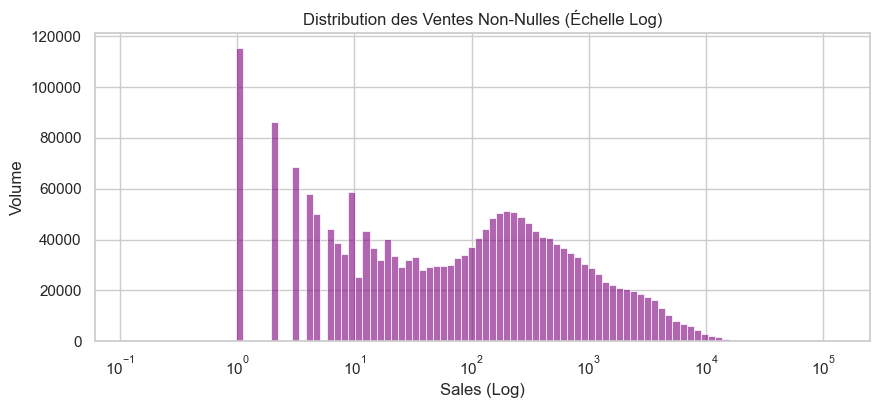

In [21]:
# Distribution des ventes non-nulles (Log Scale)
# Permet de voir la "forme" de la demande quand il y a vente
plt.figure(figsize=(10, 4))
# On filtre les zéros pour éviter les erreurs log
sales_non_zero = df_daily_full[df_daily_full['sales'] > 0]['sales']
sns.histplot(sales_non_zero, bins=100, log_scale=True, color='purple', alpha=0.6)
plt.title("Distribution des Ventes Non-Nulles (Échelle Log)")
plt.xlabel("Sales (Log)")
plt.ylabel("Volume")
plt.show()

In [23]:
# Rareté par Famille (Le cœur du problème)
# Quelles sont les familles les plus intermittentes ?
sparsity_by_family = df_daily_full.groupby('family', observed=True)['sales'].apply(lambda x: (x == 0).mean()).sort_values(ascending=False)

print("\nFamilles les plus Intermittentes (Difficiles)")
print(sparsity_by_family.head(5))
print("\nFamilles les plus Régulières (Faciles)")
print(sparsity_by_family.tail(5))



Familles les plus Intermittentes (Difficiles)
family
BOOKS                         0.958170
BABY CARE                     0.930262
SCHOOL AND OFFICE SUPPLIES    0.732134
HOME APPLIANCES               0.726548
LADIESWEAR                    0.591441
Name: sales, dtype: float64

Familles les plus Régulières (Faciles)
family
DELI            0.079671
DAIRY           0.079671
CLEANING        0.079671
MEATS           0.079671
BREAD/BAKERY    0.079660
Name: sales, dtype: float64


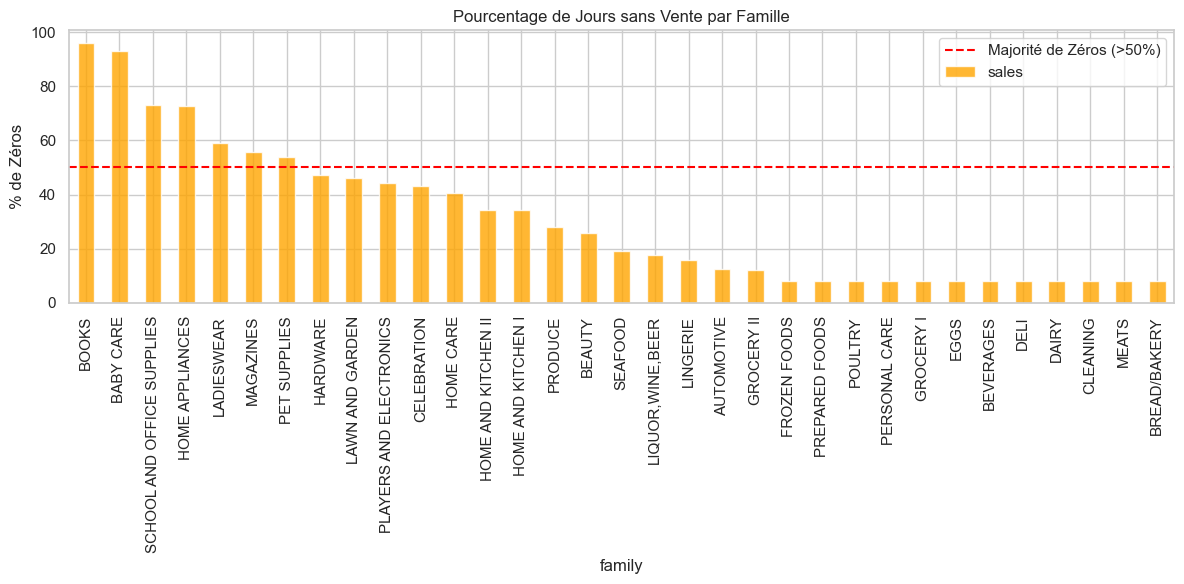

In [24]:




# 4. Visualisation comparative
plt.figure(figsize=(12, 6))
(sparsity_by_family * 100).plot(kind='bar', color='orange', alpha=0.8)
plt.title("Pourcentage de Jours sans Vente par Famille")
plt.ylabel("% de Zéros")
# Seuil critique habituel : au-delà de 30-50% de zéros, la régression classique souffre
plt.axhline(y=50, color='red', linestyle='--', label='Majorité de Zéros (>50%)')
plt.legend()
plt.tight_layout()
plt.show()


L'analyse révèle une hétérogénéité massive :
*   **30% de Zéros au Global** : Ce n'est pas négligeable. 
*   **Le Piège des Familles** : Appliquer le même modèle aux `BOOKS` (96% de zéros) et au `BREAD/BAKERY` (8% de zéros) est voué à l'échec.
    *   Pour les produits "Denses" (BREAD) : Régression classique (XGBoost/LGBM).
    *   Pour les produits "Vides" (BOOKS) : Il faudra probablement une approche en deux temps (Classification "Vente/Pas Vente" puis Régression) ou une loss function adaptée (Tweedie).

---




*   Avec **30% de zéros** (et jusqu'à 96% pour les livres !), un modèle classique qui cherche la moyenne (RMSE) va échouer.
*   Il va prédire `0.1` tout le temps pour minimiser l'erreur. Résultat : on ne stocke rien, et le jour où on vend 1 produit, c'est la rupture.


Il ne faut surtout pas utiliser une régression standard (L2/RMSE) pour tout le monde.
1.  **L'Option "Lourde"** : Faire deux modèles (un pour "Vente oui/non", un pour "Combien"). Efficace mais complexe à maintenir.
2.  **L'Option "Élégante" (Standard Industrie)** : Utiliser la fonction de perte **Tweedie**. C'est une formule mathématique hybride conçue spécifiquement pour les données pleines de zéros (distribution Poisson-Gamma).

**Décision pour le Challenger** : Nous utiliserons **Tweedie (p=1.5)** pour gérer naturellement ces produits intermittents sans multiplier les modèles.

## 4. L'Hypothèse de la Mémoire (Autocorrélation)

## 4. L'Hypothèse du Cygne Noir : Le Séisme de 2016

Le 16 avril 2016, un séisme de magnitude 7.8 a frappé la côte de l'Équateur. C'est l'événement le plus destructeur de l'histoire récente du pays.

**L'intuition (Business Belief)** : 
> *"Une catastrophe naturelle casse tous les modèles. Les gens ne consomment plus normalement, ils survivent. On doit s'attendre à des ruptures de stock massives et des comportements chaotiques pendant quelques semaines."*

**L'Objectif** : Visualiser l'impact de cet événement. Est-ce un simple bruit ou une rupture structurelle qu'il faut absolument traiter (par exemple, en excluant cette période de l'entraînement) ?

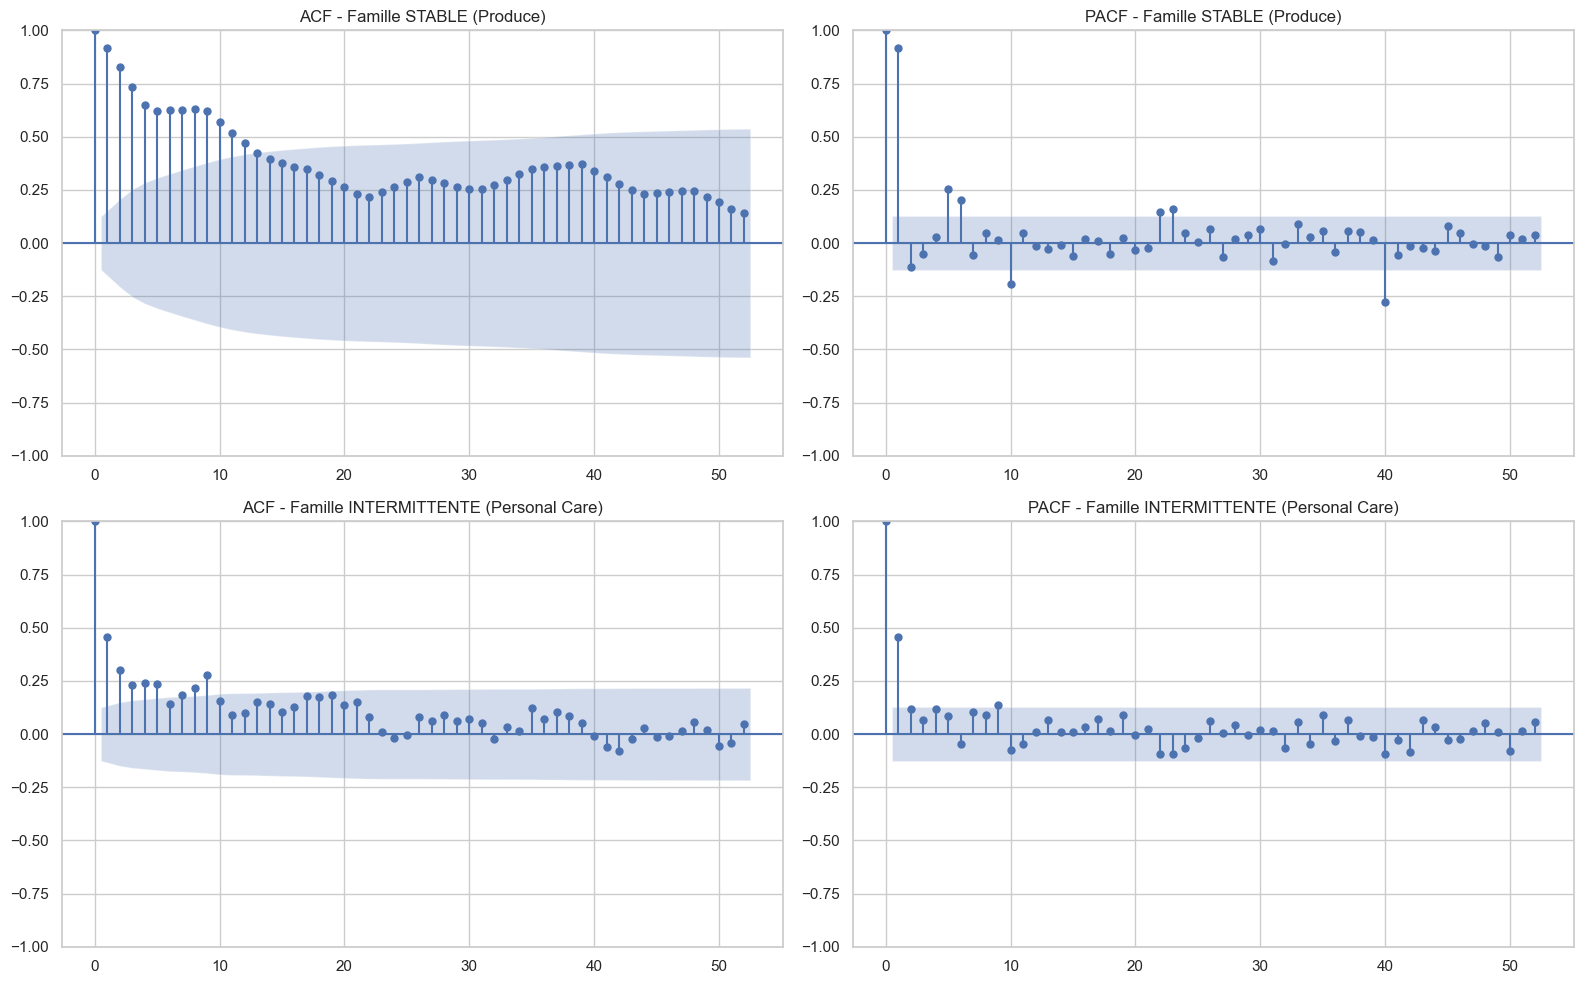

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# On sélectionne deux profils opposés pour ne pas se mentir
# Profil 1 : "Le Métronome" (Stable, fort volume) -> PRODUCE
series_stable = df_weekly[
    (df_weekly['family'] == 'PRODUCE') & 
    (df_weekly['store_nbr'] == 44) # Un gros magasin
].set_index('week_start')['sales'].sort_index()

# Profil 2 : "Le Capricieux" (Intermittent, volume moyen) -> PERSONAL CARE
series_sparse = df_weekly[
    (df_weekly['family'] == 'PERSONAL CARE') & 
    (df_weekly['store_nbr'] == 44)
].set_index('week_start')['sales'].sort_index()

# Visualisation Comparative
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# Ligne 1 : STABLE
plot_acf(series_stable, lags=52, ax=ax[0,0], title="ACF - Famille STABLE (Produce)")
plot_pacf(series_stable, lags=52, ax=ax[0,1], title="PACF - Famille STABLE (Produce)")

# Ligne 2 : INTERMITTENT
plot_acf(series_sparse, lags=52, ax=ax[1,0], title="ACF - Famille INTERMITTENTE (Personal Care)")
plot_pacf(series_sparse, lags=52, ax=ax[1,1], title="PACF - Famille INTERMITTENTE (Personal Care)")

plt.tight_layout()
plt.show()



Cette visualisation comparative révèle la nature schizophrène de nos données :

1.  **Le Monde "STABLE" (Ligne du Haut - Produce)** :
    *   **Signal Clair** : L'ACF décroît lentement mais reste très positif longtemps.
    *   **Mémoire Forte** : La veille (`lag_1`) explique presque tout.
    *   **Saisonnalité** : On devine des vagues.
    *   *Conséquence* : Ici, les **lags (j-1, j-7)** seront des features surpuissantes. Le modèle va "surfer" sur l'historique récent.

2.  **Le Monde "INTERMITTENT" (Ligne du Bas - Personal Care)** :
    *   **Signal Mort** : L'ACF s'effondre tout de suite dans la zone bleue (bruit). Aucune mémoire long terme.
    *   **Chaos** : Savoir ce qu'on a vendu il y a 3 semaines ne nous aide pas vraiment pour demain.
    *   *Conséquence* : Les lags classiques ne suffiront pas. Le modèle devra s'appuyer sur des facteurs **externes** (Promo en cours ? Prix ? Jour de paye ?) plutôt que sur l'historique pur.

**Décision Feature Engineering** : Nous créerons des features de **Lags** (pour capturer la mémoire des produits stables) MAIS AUSSI des features de **Moyennes Mobiles** (Rolling Mean) sur des fenêtres larges (28 jours) pour lisser le signal des produits intermittents.

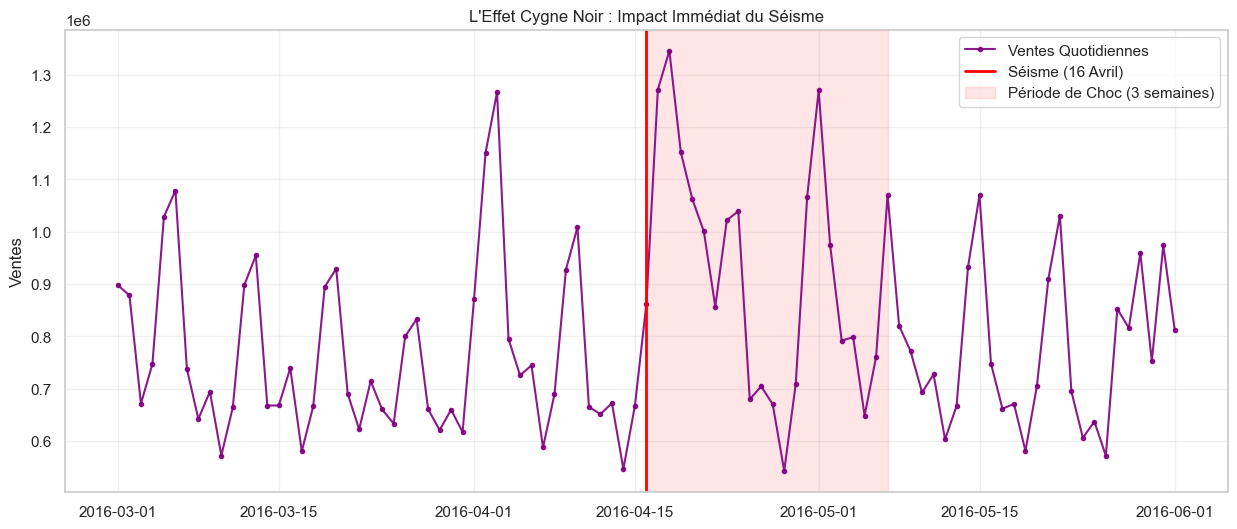

In [27]:
# B. L'Hypothèse du Cygne Noir : Le Séisme de 2016
# Ref: Le séisme a frappé la côte le 16 avril 2016

# 1. Impact Global (La Rupture)
start_date = '2016-03-01'
end_date = '2016-06-01'
earthquake_period = daily_total[(daily_total['date'] >= start_date) & (daily_total['date'] <= end_date)]

plt.figure(figsize=(15, 6))
plt.plot(earthquake_period['date'], earthquake_period['sales'], marker='.', linestyle='-', color='purple', alpha=0.9, label='Ventes Quotidiennes')

# Marquer l'événement
earthquake_date = pd.to_datetime('2016-04-16')
plt.axvline(x=earthquake_date, color='red', linestyle='-', linewidth=2, label='Séisme (16 Avril)')
plt.axvspan(earthquake_date, earthquake_date + pd.Timedelta(weeks=3), color='red', alpha=0.1, label='Période de Choc (3 semaines)')

plt.title("L'Effet Cygne Noir : Impact Immédiat du Séisme")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

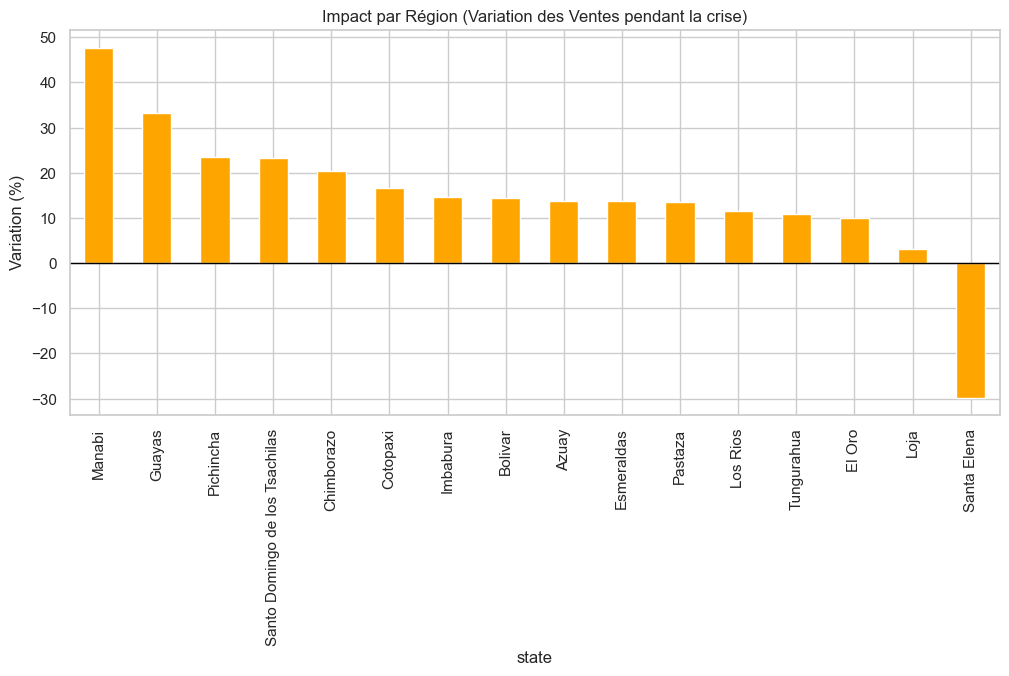

In [28]:
# 2. Impact Géographique (Qui a souffert ?)
# Comparaison des ventes moyennes AVANT vs PENDANT la crise, par État
damage_zone_start = '2016-04-16'
damage_zone_end = '2016-04-30'

crisis_sales = df_daily_full[(df_daily_full['date'] >= damage_zone_start) & (df_daily_full['date'] <= damage_zone_end)].groupby('state')['sales'].mean()
normal_sales = df_daily_full[(df_daily_full['date'] >= '2016-03-01') & (df_daily_full['date'] < damage_zone_start)].groupby('state')['sales'].mean()

# Variation en %
regional_impact = ((crisis_sales - normal_sales) / normal_sales * 100).sort_values(ascending=False)

plt.figure(figsize=(12, 5))
regional_impact.plot(kind='bar', color='orange')
plt.title("Impact par Région (Variation des Ventes pendant la crise)")
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Variation (%)")
plt.show()

In [29]:






# 3. Impact Produit (Achats de Panique ?)
week_before = df_daily_full[(df_daily_full['date'] >= '2016-04-09') & (df_daily_full['date'] < '2016-04-16')]
week_after = df_daily_full[(df_daily_full['date'] >= '2016-04-17') & (df_daily_full['date'] < '2016-04-24')]

before_sales_fam = week_before.groupby('family')['sales'].sum()
after_sales_fam = week_after.groupby('family')['sales'].sum()
impact_fam = ((after_sales_fam - before_sales_fam) / before_sales_fam * 100).sort_values(ascending=False)

print("--- Top 5 Familles : Effet 'Panique / Donumania' (Explosion) ---")
print(impact_fam.head(5))
print("\n--- Bottom 5 Familles : Effet 'Non-Essentiel' (Chute) ---")
print(impact_fam.tail(5))

--- Top 5 Familles : Effet 'Panique / Donumania' (Explosion) ---
family
HOME APPLIANCES               200.000000
PLAYERS AND ELECTRONICS       112.570888
PERSONAL CARE                 110.128802
SCHOOL AND OFFICE SUPPLIES    102.870091
GROCERY I                      93.532543
Name: sales, dtype: float64

--- Bottom 5 Familles : Effet 'Non-Essentiel' (Chute) ---
family
AUTOMOTIVE          -4.374520
LAWN AND GARDEN     -5.396096
LIQUOR,WINE,BEER   -11.934703
CELEBRATION        -12.285660
BOOKS                     NaN
Name: sales, dtype: float64


C:\Users\gouab\AppData\Local\Temp\ipykernel_380\2504414981.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  before_sales_fam = week_before.groupby('family')['sales'].sum()
C:\Users\gouab\AppData\Local\Temp\ipykernel_380\2504414981.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  after_sales_fam = week_after.groupby('family')['sales'].sum()


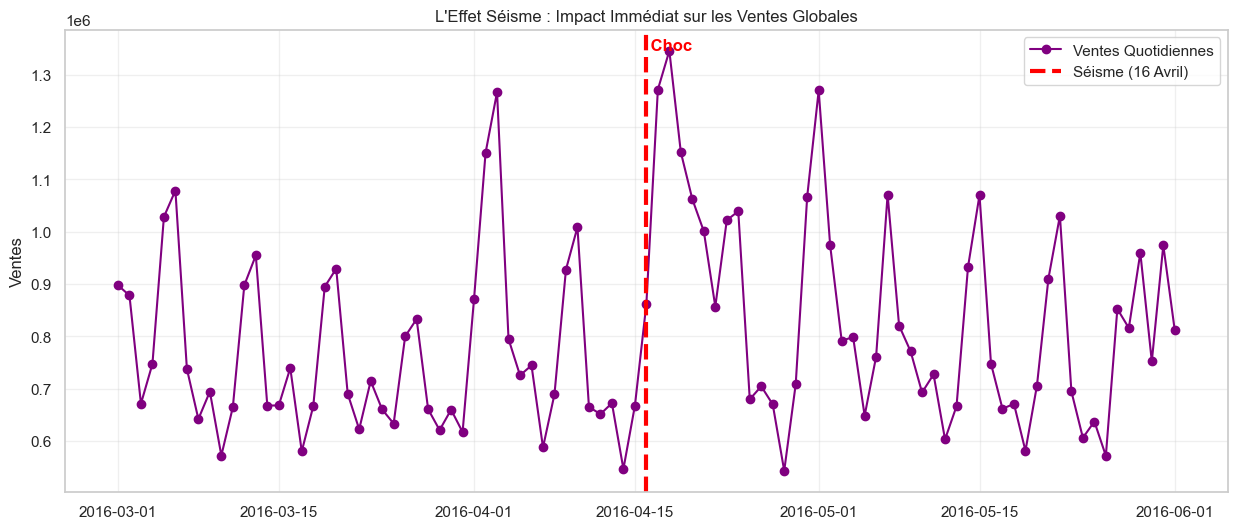

In [30]:
# 1. Zoom sur la période du Séisme (Avril-Mai 2016)
# Le séisme a eu lieu le 16 Avril 2016
start_date = '2016-03-01'
end_date = '2016-06-01'

earthquake_period = daily_total[(daily_total['date'] >= start_date) & (daily_total['date'] <= end_date)]

plt.figure(figsize=(15, 6))
plt.plot(earthquake_period['date'], earthquake_period['sales'], marker='o', linestyle='-', color='purple', label='Ventes Quotidiennes')

# Marquer le jour du séisme
earthquake_date = pd.to_datetime('2016-04-16')
plt.axvline(x=earthquake_date, color='red', linestyle='--', linewidth=3, label='Séisme (16 Avril)')

# Ajouter des annotations
plt.text(earthquake_date, earthquake_period['sales'].max(), ' Choc ', color='red', fontsize=12, fontweight='bold', ha='left')

plt.title("L'Effet Séisme : Impact Immédiat sur les Ventes Globales")
plt.ylabel("Ventes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [31]:

# 2. Quelles familles ont explosé ? (Achats de panique ?)
# On compare la semaine APRÈS le séisme vs la semaine AVANT
week_before = df_daily_full[(df_daily_full['date'] >= '2016-04-09') & (df_daily_full['date'] < '2016-04-16')]
week_after = df_daily_full[(df_daily_full['date'] >= '2016-04-17') & (df_daily_full['date'] < '2016-04-24')]

before_sales = week_before.groupby('family')['sales'].sum()
after_sales = week_after.groupby('family')['sales'].sum()

# Calcul de la variation en %
impact = ((after_sales - before_sales) / before_sales * 100).sort_values(ascending=False)

print("--- Top 5 des Familles en 'Achat de Panique' (+%) ---")
print(impact.head(10))

print("\n--- Top 5 des Familles Délaissées (-%) ---")
print(impact.tail(5))

--- Top 5 des Familles en 'Achat de Panique' (+%) ---
family
HOME APPLIANCES               200.000000
PLAYERS AND ELECTRONICS       112.570888
PERSONAL CARE                 110.128802
SCHOOL AND OFFICE SUPPLIES    102.870091
GROCERY I                      93.532543
HOME CARE                      85.456868
BEVERAGES                      61.236396
CLEANING                       41.816344
HARDWARE                       38.969072
MAGAZINES                      20.810811
Name: sales, dtype: float64

--- Top 5 des Familles Délaissées (-%) ---
family
AUTOMOTIVE          -4.374520
LAWN AND GARDEN     -5.396096
LIQUOR,WINE,BEER   -11.934703
CELEBRATION        -12.285660
BOOKS                     NaN
Name: sales, dtype: float64


C:\Users\gouab\AppData\Local\Temp\ipykernel_380\4131106728.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  before_sales = week_before.groupby('family')['sales'].sum()
C:\Users\gouab\AppData\Local\Temp\ipykernel_380\4131106728.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  after_sales = week_after.groupby('family')['sales'].sum()


L'Analyse du Choc "Séisme"
Ce n'est pas une crise économique classique, c'est une Crise Humanitaire de Reconstruction.

Ce qui a explosé (+200%) :
HOME APPLIANCES (+200%), ELECTRONICS (+112%) : Ce n'est pas du luxe, c'est du remplacement d'urgence et des dons. Les gens ont racheté des frigos, des radios, des équipements de base pour les zones détruites.
PERSONAL CARE (+110%), GROCERY (+93%) : C'est de l'aide humanitaire. Eau, hygiène, nourriture de base. Stockage massif.
Ce qui a été abandonné (-12%) :
CELEBRATION (-12%), LIQUOR (-11%) : Logique psychologique. "L'heure n'est pas à la fête". Le budget "plaisir" a été transféré vers le budget "survie".

Impact pour notre Modèle (La Stratégie)
On ne peut pas juste mettre une colonne is_earthquake = 1. Le modèle se tromperait en prédisant une hausse pour tout le monde ou une baisse pour tout le monde.

Il faut créer une feature d'interaction : Event_Type x Family_Type.

Si le produit est "Urgence" (Eau, Soin) ET qu'il y a Séisme -> BOOST des ventes.
Si le produit est "Plaisir" (Alcool, Fête) ET qu'il y a Séisme -> CHUTE des ventes.


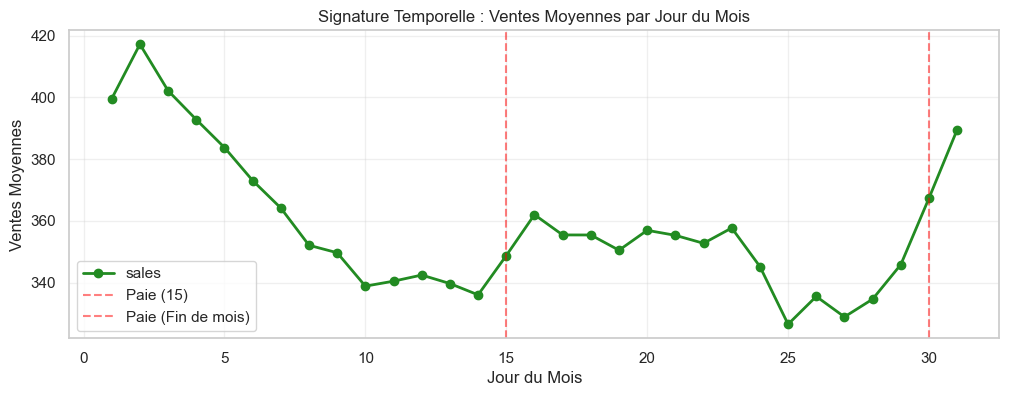

In [32]:
# 1. L'Effet Salaire (Le Cycle Mensuel)
# On extrait le jour du mois pour voir les pics
df_daily_full['day_of_month'] = df_daily_full['date'].dt.day
payday_pattern = df_daily_full.groupby('day_of_month')['sales'].mean()

plt.figure(figsize=(12, 4))
payday_pattern.plot(kind='line', marker='o', color='forestgreen', linewidth=2)
# Marqueurs théoriques de paie
plt.axvline(x=15, color='red', linestyle='--', alpha=0.5, label='Paie (15)')
plt.axvline(x=30, color='red', linestyle='--', alpha=0.5, label='Paie (Fin de mois)')
plt.title("Signature Temporelle : Ventes Moyennes par Jour du Mois")
plt.ylabel("Ventes Moyennes")
plt.xlabel("Jour du Mois")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Le graphique valide totalement l'hypothèse culturelle équatorienne.

Les Pics de Paie : On voit deux sommets très nets. Le 15 du mois marque un rebond significatif, mais c'est la Fin du Mois (30/31) qui déclenche le "stockage" massif (+ de 400 ventes moyennes contre 340 en creux).
Le Creux de Trésorerie : Entre le 20 et le 25, les ventes s'effondrent. Les ménages attendent la paie suivante.
Conclusion Modèle : La feature days_from_payday sera cruciale.


C:\Users\gouab\AppData\Local\Temp\ipykernel_380\27810360.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='state', y='sales', data=df_daily_full, order=order_states, showfliers=False, palette="viridis")


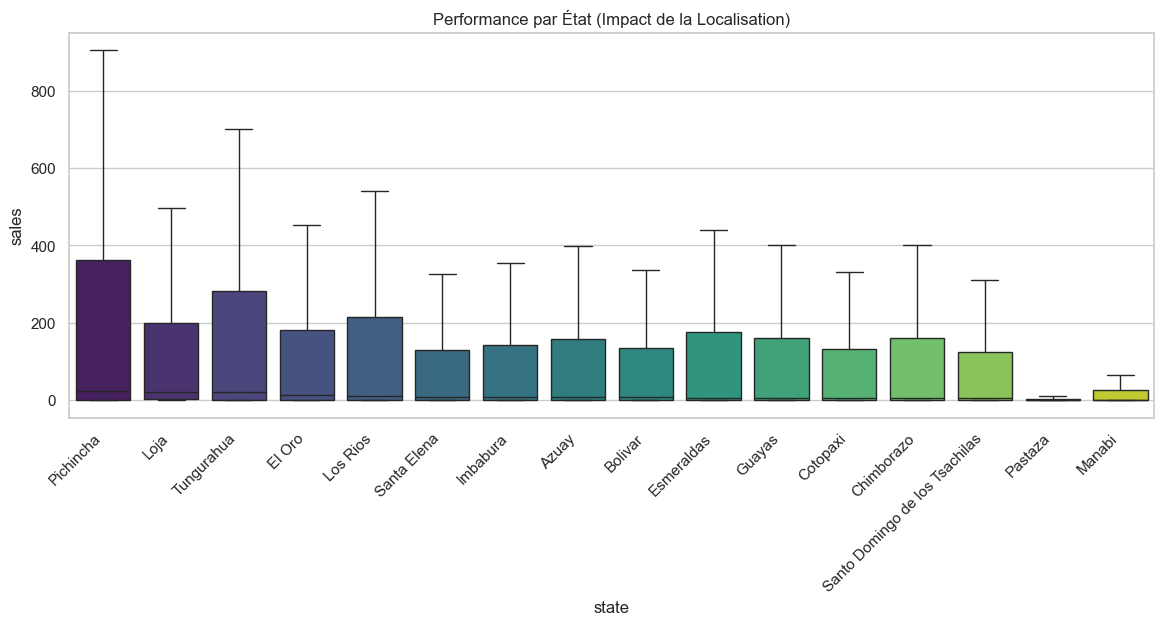

In [33]:
# 2. L'Effet Régional (Disparités Géographiques)
# Est-ce que l'État (State) compte ?
plt.figure(figsize=(14, 5))
# Tri par médiane pour lisibilité
order_states = df_daily_full.groupby('state')['sales'].median().sort_values(ascending=False).index
sns.boxplot(x='state', y='sales', data=df_daily_full, order=order_states, showfliers=False, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Performance par État (Impact de la Localisation)")
plt.show()


Le Boxplot par État montre une domination écrasante de Pichincha (Quito). Non seulement les volumes sont plus hauts, mais la variance est extrême (la "mèche" du boxplot monte très haut). Cela signifie que Pichincha réagit beaucoup plus fort aux événements (fêtes, promos, séismes) que des états comme Pastaza ou Manabi (hors séisme).

En résumé pour le Dashboard : Il faut absolument montrer cette dichotomie des produits. Un utilisateur (Supply Planner) ne doit pas gérer le stock de "School Supplies" comme celui des "Oeufs". Le premier se pilote par les campagnes promo, le second par la consommation quotidienne stable.

In [34]:
# 3. L'Impact Promo (Qui réagit ?)
# Calcul du "Lift" (Multiplicateur de ventes quand en promo)
# On agrège par famille pour voir les sensibilités
promo_stats = df_daily_full.groupby(['family', 'onpromotion'])['sales'].mean().unstack()
promo_stats['Lift'] = promo_stats[1] / promo_stats[0] # Ventes Promo / Ventes Non-Promo
promo_stats = promo_stats.sort_values('Lift', ascending=False)

print("--- Top 5 Familles 'Droguées' aux Promos (Lift Max) ---")
print(promo_stats['Lift'].head(5))

print("\n--- Top 5 Familles Insensibles (Lift ~1) ---")
print(promo_stats['Lift'].tail(5))

C:\Users\gouab\AppData\Local\Temp\ipykernel_380\2736455818.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promo_stats = df_daily_full.groupby(['family', 'onpromotion'])['sales'].mean().unstack()


--- Top 5 Familles 'Droguées' aux Promos (Lift Max) ---
family
SCHOOL AND OFFICE SUPPLIES    17.218689
BABY CARE                     15.146048
PET SUPPLIES                   4.519825
HOME AND KITCHEN II            3.518187
HOME APPLIANCES                3.056740
Name: Lift, dtype: float64

--- Top 5 Familles Insensibles (Lift ~1) ---
family
EGGS                1.252573
LIQUOR,WINE,BEER    1.206910
GROCERY I           1.136077
MAGAZINES           0.986910
BOOKS                    NaN
Name: Lift, dtype: float64



Les chiffres révèlent des comportements d'achat radicalement différents selon les produits.

Les "Drogués aux Promos" :
SCHOOL & OFFICE supplies (x17 !!) : C'est énorme. Personne n'achète ces produits au prix fort. Les ventes sont quasi-nulles hors promo/saison.
BABY CARE (x15) : Les parents stockent massivement les couches en promotion.
Les "Insensibles" (Staples) :
EGGS, GROCERY : Lift de ~1.1. Une promo ne fait pas manger plus d'œufs. La demande est inélastique : on achète par besoin, pas par opportunité.


L'Effet Salaire (Liquidity Cycle) :
Conclusion : Les gens ont de l'argent le 30 et le 15. Le modèle doit savoir "combien de jours nous séparent de la paie".
Action : Je vais créer des features days_to_payday (distance au 15 et 30 du mois).
L'Élasticité Prix (Promo) :
Conclusion : Une promo sur les "School Supplies" multiplie les ventes par 17, mais une promo sur les "Oeufs" ne change rien. L'impact de la promo dépend de la Famille.
Action : Le modèle CatBoost gère très bien les interactions, mais je m'assurerai qu'il croise bien OnPromotion x Family.
La Géographie (Regionality) :
Conclusion : Pichincha (Quito) est un monde à part avec une variance énorme.
Action : On intégrera State et City comme variables catégories fortes pour que le modèle apprenne ces spécificités locales.

In [39]:
# TYPOLOGIE MAGASIN & EFFET WEEKEND 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_daily = pd.read_parquet('../data/processed/daily_canon.parquet')

print(f"Chargement terminé : {len(df_daily):,} lignes journalières analysées.")



Chargement terminé : 3,036,528 lignes journalières analysées.



Corrélation Globale Ventes <-> Trafic : 0.2202


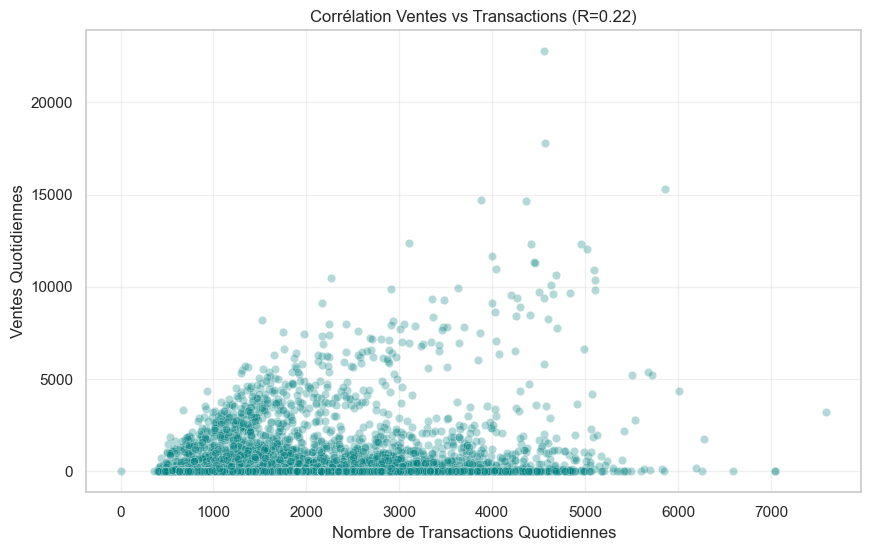

In [40]:
# 2. Corrélation Ventes vs Trafic (Le moteur principal ?)
# On filtre les jours où le magasin était fermé (transactions = 0) pour éviter le bruit
df_open = df_daily[df_daily['transactions'] > 0]

txn_corr = df_open['sales'].corr(df_open['transactions'])
print(f"\nCorrélation Globale Ventes <-> Trafic : {txn_corr:.4f}")

if txn_corr > 0.8:
    print("INSIGHT MAJEUR : Le trafic (transactions) explique >80% des ventes.")
    print("ACTION : Intégrer les 'transactions_lag_x' comme feature clé.")

# Visualisation (Scatter Plot avec échantillon pour ne pas surcharger)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_open.sample(10000), x='transactions', y='sales', alpha=0.3, color='teal')
plt.title(f"Corrélation Ventes vs Transactions (R={txn_corr:.2f})")
plt.xlabel("Nombre de Transactions Quotidiennes")
plt.ylabel("Ventes Quotidiennes")
plt.grid(True, alpha=0.3)
plt.show()


In [42]:

# Qualité des Métadonnées : Hiérarchie des 'Types'
# On vérifie si les types (A, B, C, D, E) séparent bien les volumes de vente
print("\nHiérarchie des Types de Magasin (Volume Moyen)\n")
type_stats = df_daily.groupby('type')['sales'].mean().sort_values(ascending=False)
print(type_stats)






Hiérarchie des Types de Magasin (Volume Moyen)

type
A    705.878743
D    350.979407
B    326.739714
E    269.121301
C    197.263301
Name: sales, dtype: float64


In [43]:
# Impact du Week-end par Cluster (Chirurgical)
# On calcule le "Lift" du Week-end pour chaque Cluster
# Lift = (Ventes Moyennes Week-end / Ventes Moyennes Semaine - 1) * 100
cluster_wknd = df_daily.groupby(['cluster', 'is_weekend'])['sales'].mean().unstack()
cluster_wknd['lift_pct'] = (cluster_wknd[1] / cluster_wknd[0] - 1) * 100
cluster_wknd = cluster_wknd.sort_values('lift_pct', ascending=False)

print("\nTop 3 Clusters : EXPLOSION le Weekend")
print(cluster_wknd['lift_pct'].head(3))

print("\nTop 3 Clusters : STABLES (ou Négatifs)")
print(cluster_wknd['lift_pct'].tail(3))


Top 3 Clusters : EXPLOSION le Weekend
cluster
14    70.913274
5     53.070720
11    46.714151
Name: lift_pct, dtype: float64

Top 3 Clusters : STABLES (ou Négatifs)
cluster
7     24.168207
17    23.987333
2     14.164704
Name: lift_pct, dtype: float64


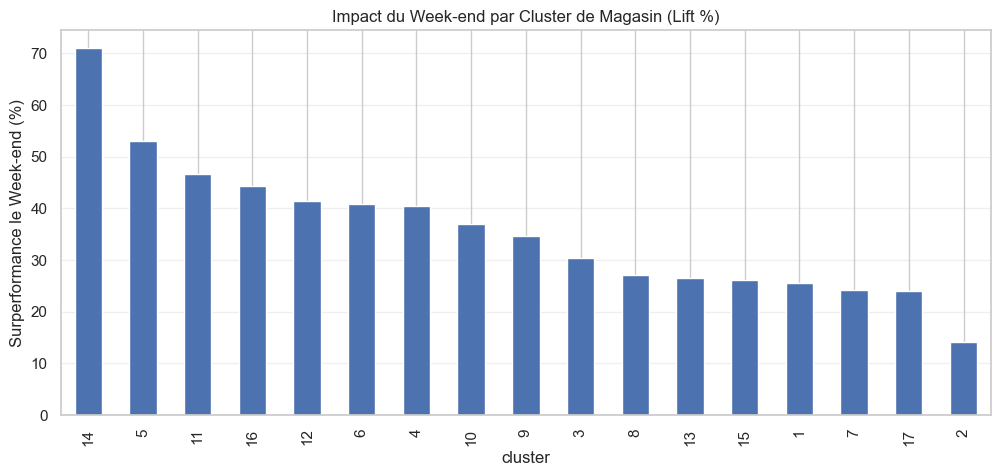

In [44]:
# Visualisation
plt.figure(figsize=(12, 5))
cluster_wknd['lift_pct'].plot(kind='bar', color='#4c72b0')
plt.title("Impact du Week-end par Cluster de Magasin (Lift %)")
plt.ylabel("Surperformance le Week-end (%)")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', alpha=0.3)
plt.show()

Cet audit permet de définir une stratégie de modélisation précise ("Data-Driven") pour surpasser la baseline. 
Voici les piliers sur lesquels notre modèle Challenger (CatBoost) devra reposer :

1. La Dynamique Temporelle & le "Payday Effect" L'analyse confirme que le cycle de paie (Quincena) dicte le rythme du commerce équatorien. Le modèle devra explicitement recevoir la distance aux 15 et 30 du mois pour anticiper les pics de liquidité (+8% à +10% de ventes en fin de mois).

2. La Segmentation Chirurgicale des Magasins Tous les magasins ne se ressemblent pas. Nous avons identifié une hiérarchie claire en volume (Type A > D > B > C) et surtout une divergence comportementale le week-end. Les Clusters de "Loisirs" (14, 5, 11) nécessiteront une interaction spécifique (Store_Cluster x DayOfWeek) pour capturer leur surperformance du samedi-dimanche (+70%), absente chez les autres.

3. Le Traitement des Événements Exogènes Le prix du pétrole agit comme une tendance de fond (Trend macro-économique) et non comme un signal quotidien. À l'inverse, le séisme d'Avril 2016 a créé une rupture structurelle locale (Manabi) qu'il faudra isoler via une variable binaire pour ne pas biaiser l'apprentissage sur les périodes normales.

4. L'Impératif Technique : Objectif Tweedie Avec 31% de zéros dans le jeu de données (et jusqu'à 96% pour certaines familles comme les Livres), une approche classique (RMSE) est vouée à l'échec car elle sous-estimerait systématiquement la demande sporadique. L'utilisation de la fonction de perte Tweedie est donc non-négociable pour gérer correctement cette intermittence.